In [ ]:

# Install all PyTorch Geometric dependencies (CPU version)
!pip install --upgrade pip setuptools wheel
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch_geometric
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 80.0.0
    Uninstalling setuptools-80.0.0:
      Successfully uninstalled setuptools-80.0.0 0/2 [setuptools]
  Attempting uninstall: pip━━━━━━━━━━━━━━━━━━━━━ 0/2 [setuptools]
    Found existing installation: pip 25.1━━━ 0/2 [setuptools]
    Uninstalling pip-25.1:━━╺━━━━━━━━━━━━━━━━━━━ 1/2 [pip]
      Successfully uninstalled pip-25.1━━━━━━━━━━━━━━━━━━━ 1/2 [pip]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pip]1/2 [pip]
Looking in indexes: https://download.pytorch.org/whl/cpu


In [40]:
# Import libraries and load data
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, GATConv, GraphNorm, MessagePassing
from torch_geometric.utils import softmax, scatter
from sklearn.metrics import f1_score, precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import copy

# Load train, val, and test sets
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

# Wrap in data loaders for batch training
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of nodes in first graph: {train_dataset[0].num_nodes}")
print(f"Feature shape: {train_dataset[0].x.shape}")
print(f"Labels shape: {train_dataset[0].y.shape}")


Number of training graphs: 20
Number of nodes in first graph: 1767
Feature shape: torch.Size([1767, 50])
Labels shape: torch.Size([1767, 121])


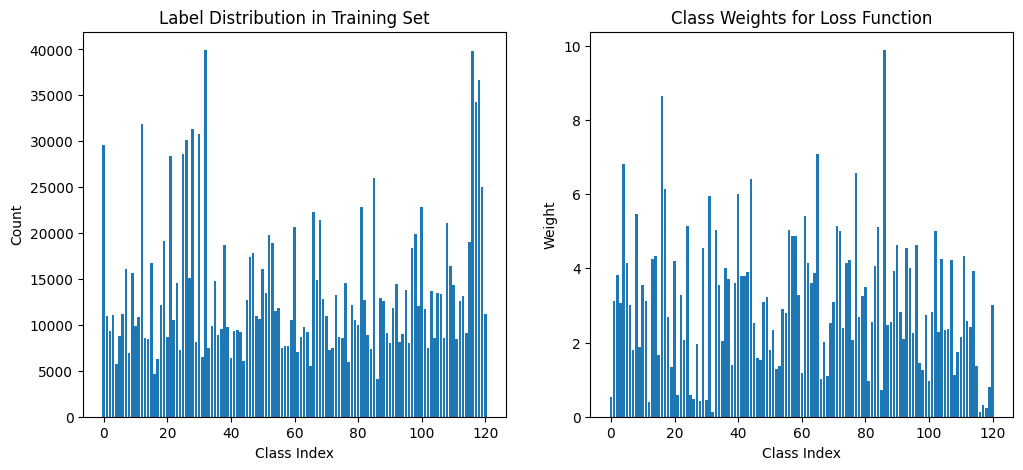

In [3]:
#Compute and graph class-wise positive label counts and weights
def compute_pos_weights(loader):
    total_pos = torch.zeros(train_dataset.num_classes)
    total_count = 0
    for batch in loader:
        total_pos += batch.y.sum(dim=0)
        total_count += batch.y.size(0)
    neg = total_count - total_pos
    pos_weight = neg / (total_pos + 1e-6)
    return total_pos, pos_weight

label_distribution, class_weights = compute_pos_weights(train_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

# Plot label distribution and class weights
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(range(len(label_distribution)), label_distribution.numpy())
axs[0].set_title("Label Distribution in Training Set")
axs[0].set_xlabel("Class Index")
axs[0].set_ylabel("Count")

axs[1].bar(range(len(class_weights)), class_weights.cpu().numpy())
axs[1].set_title("Class Weights for Loss Function")
axs[1].set_xlabel("Class Index")
axs[1].set_ylabel("Weight")
plt.show()

In [4]:
# Training curve function
def plot_graphs(train_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label='Validation F1', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 over Epochs')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# GraphSAGE model definition
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.conv2 = SAGEConv(hidden_feats, out_feats)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [33]:
# DeepGraphSAGE model definition -- with GraphNorm layer norm
class DeepGraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(DeepGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.norm1 = GraphNorm(hidden_feats)

        self.conv2 = SAGEConv(hidden_feats, hidden_feats)
        self.norm2 = GraphNorm(hidden_feats)

        self.conv3 = SAGEConv(hidden_feats, hidden_feats)
        self.norm3 = GraphNorm(hidden_feats)

        self.conv4 = SAGEConv(hidden_feats, hidden_feats)
        self.norm4 = GraphNorm(hidden_feats)

        self.conv5 = SAGEConv(hidden_feats, out_feats)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.05)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.norm1(x, batch)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.norm2(x, batch)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.norm3(x, batch)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.norm4(x, batch)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv5(x, edge_index)  # NOTE: no sigmoid here
        return x

In [ ]:
# GAT model definition
class GAT(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, heads=4):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_feats, hidden_feats, heads=heads)
        self.norm1 = GraphNorm(hidden_feats * heads)
        self.gat2 = GATConv(hidden_feats * heads, hidden_feats, heads=heads)
        self.norm2 = GraphNorm(hidden_feats * heads)
        self.gat3 = GATConv(hidden_feats * heads, hidden_feats, heads=heads)
        self.norm3 = GraphNorm(hidden_feats * heads)
        self.gat4 = GATConv(hidden_feats * heads, out_feats, heads=1)
        self.activation = nn.ELU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, edge_index, batch):
        x = self.gat1(x, edge_index)
        x = self.norm1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.gat2(x, edge_index)
        x = self.norm2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.gat3(x, edge_index)
        x = self.norm3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.gat4(x, edge_index)
        return x

In [21]:
# Attention-based GraphSAGE layer definition
class LearnableAggregatorConv(MessagePassing):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super(LearnableAggregatorConv, self).__init__(aggr=None)  # Custom aggregation
        self.lin = nn.Linear(in_channels, out_channels)
        self.att_mlp = nn.Sequential(
            nn.Linear(2 * out_channels, out_channels),
            nn.LeakyReLU(0.2),
            nn.Linear(out_channels, 1)
        )
        self.gate = nn.Sequential(
            nn.Linear(out_channels * 3, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, 3)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.lin(x)
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j, index, ptr, size_i):
        # --- Attention aggregation ---
        x_cat = torch.cat([x_i, x_j], dim=-1)
        att_weight = self.att_mlp(x_cat).squeeze(-1)
        att_weight = softmax(att_weight, index, ptr, size_i)
        att_weight = self.dropout(att_weight)
        att_msg = att_weight.unsqueeze(-1) * x_j
        att_out = scatter(att_msg, index, dim=0, dim_size=size_i, reduce='sum')

        # --- Mean aggregation ---
        mean_out = scatter(x_j, index, dim=0, dim_size=size_i, reduce='mean')

        # --- Max aggregation ---
        max_out = scatter(x_j, index, dim=0, dim_size=size_i, reduce='max')

        # --- Combine with gating ---
        cat_aggr = torch.cat([mean_out, max_out, att_out], dim=-1)  # [N, 3D]
        gate_logits = self.gate(cat_aggr)  # [N, 3]
        gate_weights = F.softmax(gate_logits, dim=-1)  # [N, 3]

        # Apply weights
        fused = (
            gate_weights[:, 0:1] * mean_out +
            gate_weights[:, 1:2] * max_out +
            gate_weights[:, 2:3] * att_out
        )
        return fused

    def update(self, aggr_out, x):
        return aggr_out + x  # Optional residual
    def aggregate(self, inputs, index, ptr=None, dim_size=None):
        # This should never be called, as aggregation is done manually in `message`
        return inputs


In [ ]:
# Hybrid Attention-based GraphSage GNN Model
class HybridGNN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, dropout=0.05):
        super(HybridGNN, self).__init__()
        self.conv1 = LearnableAggregatorConv(in_feats, hidden_feats, dropout)
        self.norm1 = GraphNorm(hidden_feats)

        self.conv2 = LearnableAggregatorConv(hidden_feats, hidden_feats, dropout)
        self.norm2 = GraphNorm(hidden_feats)

        self.conv3 = LearnableAggregatorConv(hidden_feats, hidden_feats, dropout)
        self.norm3 = GraphNorm(hidden_feats)

        self.conv4 = LearnableAggregatorConv(hidden_feats, out_feats, dropout)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.norm1(x, batch)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.norm2(x, batch)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.norm3(x, batch)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        return x 


In [31]:
# Evaluation helper
# Evaluation helper
def evaluate(model, loader):
    model.eval()
    total_f1 = 0
    total_precision = 0
    total_recall = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = torch.sigmoid(model(batch.x, batch.edge_index, batch.batch))  # Apply sigmoid here for weigted BCE loss. # batch argument for graphnorm
            preds = (out > 0.5).float()

            y_true = batch.y.cpu().numpy()
            y_pred = preds.cpu().numpy()

            f1 = f1_score(y_true, y_pred, average='micro')
            precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
            recall = recall_score(y_true, y_pred, average='micro', zero_division=0)

            total_f1 += f1
            total_precision += precision
            total_recall += recall

    n_batches = len(loader)
    return total_f1 / n_batches, total_precision / n_batches, total_recall / n_batches

# Training function
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=125, patience=15):
    train_losses = []
    val_f1_scores = []
    best_val_f1 = 0
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)     # batch argument for graphnorm
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_f1, precision, recall = evaluate(model, val_loader)

        train_losses.append(avg_loss)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}, Val F1: {val_f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, val_f1_scores

In [47]:
# Run Hybrid Model
# Init
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridGNN(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))       # Changed from:  loss_fn = nn.BCELoss()

# Train
train_losses, val_f1_scores = train_model(model, train_loader, val_loader, optimizer, loss_fn)

# Validate and Test
val_f1, val_recall, val_precision = evaluate(model, val_loader)
test_f1, test_recall, test_precision = evaluate(model, test_loader)
print(f"\nValidation F1: {val_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
plot_graphs(train_losses, val_f1_scores)

TypeError: forward() takes 3 positional arguments but 4 were given

In [ ]:
# Run GraphSAGE 
# Init model, optimizer, loss
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGE(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)                # Changed from:  loss_fn = nn.BCELoss()

# Train
train_losses, val_f1_scores = train_model(model, train_loader, val_loader, optimizer, loss_fn)

# Final test evaluation
val_f1, val_recall, val_precision = evaluate(model, val_loader)
test_f1, test_recall, test_precision = evaluate(model, test_loader)
print(f"\nValidation F1: {val_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
plot_graphs(train_losses, val_f1_scores)


Epoch 1/125, Loss: 0.8880, Val F1: 0.5755, Precision: 0.4587, Recall: 0.7722
Epoch 2/125, Loss: 0.7395, Val F1: 0.6363, Precision: 0.5275, Recall: 0.8018
Epoch 3/125, Loss: 0.6420, Val F1: 0.6768, Precision: 0.5692, Recall: 0.8347
Epoch 4/125, Loss: 0.5693, Val F1: 0.7207, Precision: 0.6504, Recall: 0.8079
Epoch 5/125, Loss: 0.4944, Val F1: 0.7553, Precision: 0.6875, Recall: 0.8379
Epoch 6/125, Loss: 0.4438, Val F1: 0.7831, Precision: 0.7255, Recall: 0.8505
Epoch 7/125, Loss: 0.3861, Val F1: 0.8148, Precision: 0.7681, Recall: 0.8676
Epoch 8/125, Loss: 0.3413, Val F1: 0.8363, Precision: 0.7975, Recall: 0.8792
Epoch 9/125, Loss: 0.3033, Val F1: 0.8560, Precision: 0.8093, Recall: 0.9085
Epoch 10/125, Loss: 0.2712, Val F1: 0.8686, Precision: 0.8261, Recall: 0.9156
Epoch 11/125, Loss: 0.2574, Val F1: 0.8764, Precision: 0.8341, Recall: 0.9233
Epoch 12/125, Loss: 0.2325, Val F1: 0.8867, Precision: 0.8382, Recall: 0.9411
Epoch 13/125, Loss: 0.2126, Val F1: 0.8921, Precision: 0.8486, Recall: 0.

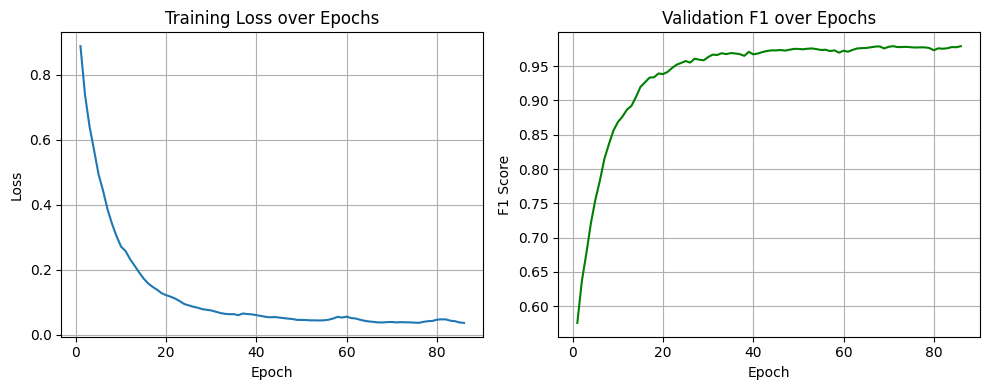

In [39]:
# Run DeepGraphSAGE
# Init
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepGraphSAGE(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))       # Changed from:  loss_fn = nn.BCELoss()

# Train
train_losses, val_f1_scores = train_model(model, train_loader, val_loader, optimizer, loss_fn)

# Validate and Test
val_f1, val_recall, val_precision = evaluate(model, val_loader)
test_f1, test_recall, test_precision = evaluate(model, test_loader)
print(f"\nValidation F1: {val_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
plot_graphs(train_losses, val_f1_scores)


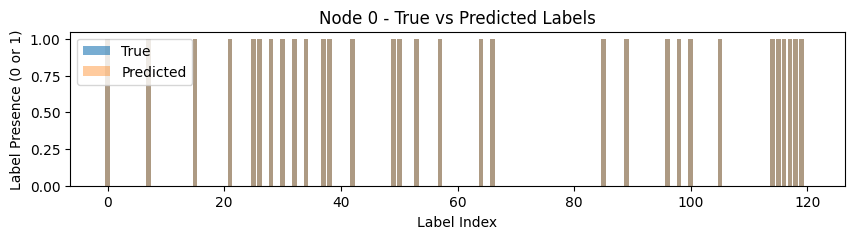

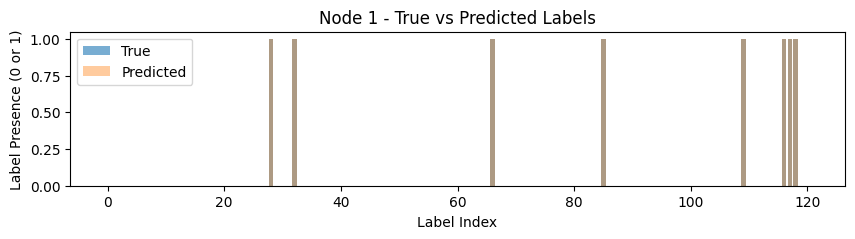

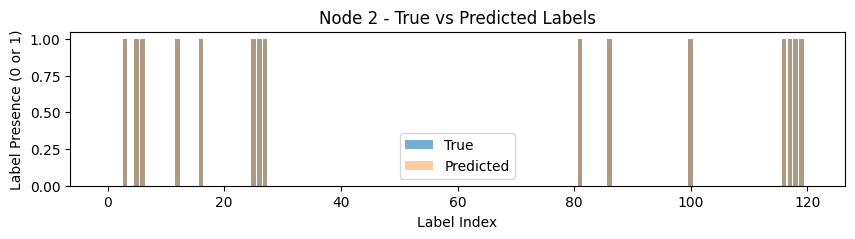

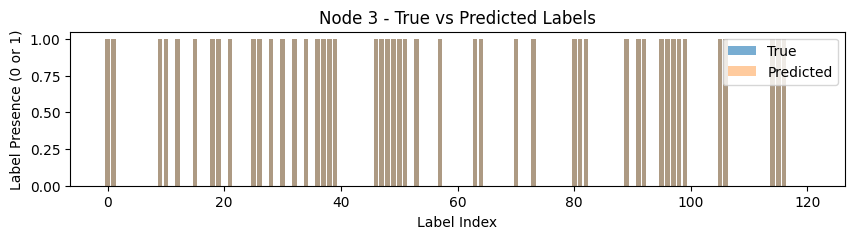

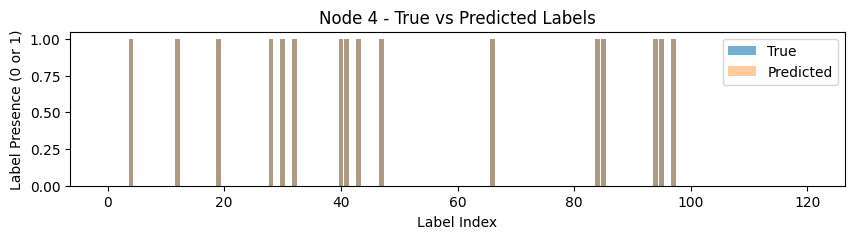

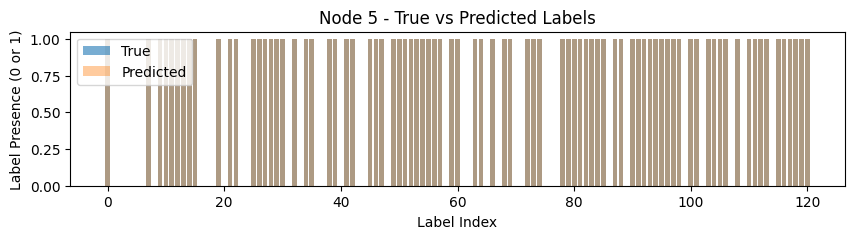

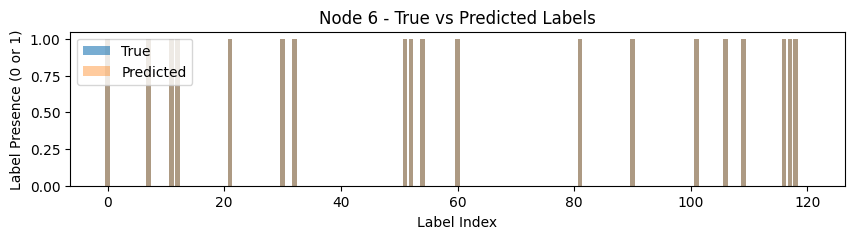

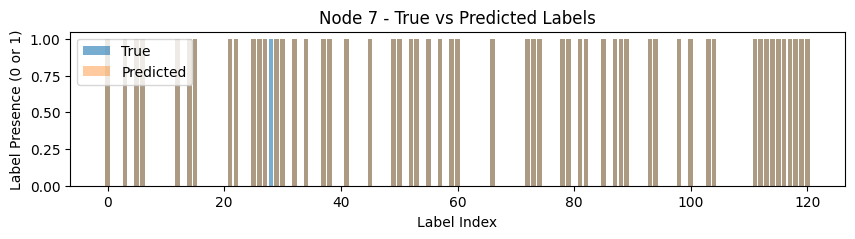

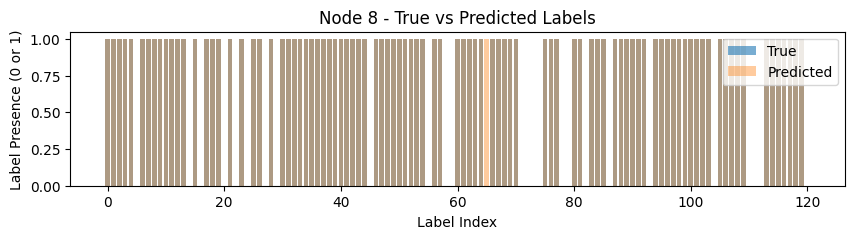

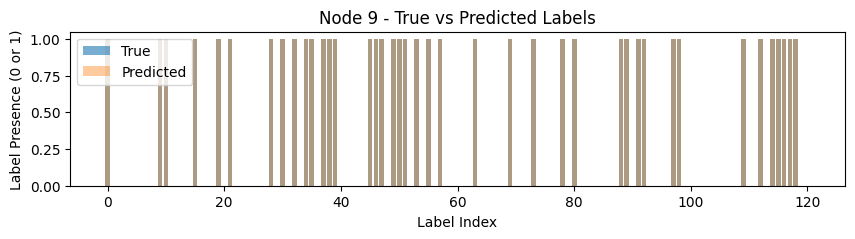

In [38]:
# Visualize predictions for the first graph in test set
model.eval()
sample = test_dataset[0].to(device)

with torch.no_grad():
    pred = model(sample.x, sample.edge_index, batch=None)  # No batch argument for single graph
    pred_bin = (pred > 0.5).float().cpu()

# Plot true vs predicted labels for first 5 nodes
num_nodes_to_plot = 10
for i in range(num_nodes_to_plot):
    plt.figure(figsize=(10, 2))
    plt.bar(range(out_feats), sample.y[i].cpu(), alpha=0.6, label='True')
    plt.bar(range(out_feats), pred_bin[i], alpha=0.4, label='Predicted')
    plt.title(f"Node {i} - True vs Predicted Labels")
    plt.xlabel("Label Index")
    plt.ylabel("Label Presence (0 or 1)")
    plt.legend()
    plt.show()


Epoch 1/100, Loss: 0.9599, Val F1: 0.4689
Epoch 2/100, Loss: 0.9496, Val F1: 0.4701
Epoch 3/100, Loss: 0.9377, Val F1: 0.4814
Epoch 4/100, Loss: 0.9407, Val F1: 0.4702
Epoch 5/100, Loss: 0.9325, Val F1: 0.4752
Epoch 6/100, Loss: 0.9559, Val F1: 0.4524
Epoch 7/100, Loss: 0.9366, Val F1: 0.4864
Epoch 8/100, Loss: 0.9415, Val F1: 0.4626
Epoch 9/100, Loss: 0.9402, Val F1: 0.4628
Epoch 10/100, Loss: 0.9258, Val F1: 0.4472
Epoch 11/100, Loss: 0.9115, Val F1: 0.4777
Epoch 12/100, Loss: 0.9102, Val F1: 0.4621
Epoch 13/100, Loss: 0.9183, Val F1: 0.4958
Epoch 14/100, Loss: 0.9051, Val F1: 0.4889
Epoch 15/100, Loss: 0.8986, Val F1: 0.4955
Epoch 16/100, Loss: 0.8951, Val F1: 0.4838
Epoch 17/100, Loss: 0.8963, Val F1: 0.4988
Epoch 18/100, Loss: 0.8967, Val F1: 0.5043
Epoch 19/100, Loss: 0.8945, Val F1: 0.4963
Epoch 20/100, Loss: 0.8909, Val F1: 0.5064
Epoch 21/100, Loss: 0.8896, Val F1: 0.4921
Epoch 22/100, Loss: 0.8801, Val F1: 0.4830
Epoch 23/100, Loss: 0.8808, Val F1: 0.4989
Epoch 24/100, Loss: 

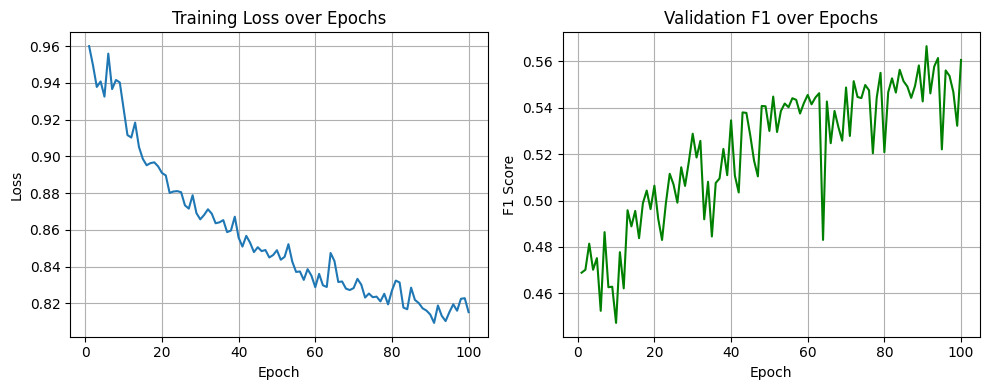

In [ ]:
# Run GAT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 512
model = GAT(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))       # Changed from:  loss_fn = nn.BCELoss()

# Train the GAT model
train_losses, val_f1_scores = train_model(model, train_loader, val_loader, optimizer, loss_fn)

# Final test performance
val_f1, val_recall, val_precision = evaluate(model, val_loader)
test_f1, test_recall, test_precision = evaluate(model, test_loader)
print(f"\nValidation F1: {val_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
plot_graphs(train_losses, val_f1_scores)

In [ ]:
## Run Hybrid GAT-GraphSage model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 512
model = HybridGNN(in_feats, hidden_feats, out_feats, 121).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))       # Changed from:  loss_fn = nn.BCELoss()

# Train the GAT model
train_losses, val_f1_scores = train_model(model, train_loader, val_loader, optimizer, loss_fn)

# Final test performance
val_f1, val_recall, val_precision = evaluate(model, val_loader)
test_f1, test_recall, test_precision = evaluate(model, test_loader)
print(f"\nValidation F1: {val_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
plot_graphs(train_losses, val_f1_scores)

In [ ]:
# Switch model to eval mode
model.eval()

# Get first validation graph
sample = val_dataset[0].to(device)

# Predict
with torch.no_grad():
    pred = model(sample.x, sample.edge_index)
    pred_bin = (pred > 0.5).float().cpu()

# Plot true vs predicted labels for first 5 nodes
num_nodes_to_plot = 5
for i in range(num_nodes_to_plot):
    plt.figure(figsize=(10, 2))
    plt.bar(range(out_feats), sample.y[i].cpu(), alpha=0.6, label='True')
    plt.bar(range(out_feats), pred_bin[i], alpha=0.4, label='Predicted')
    plt.title(f"Validation Node {i} - True vs Predicted Labels")
    plt.xlabel("Label Index")
    plt.ylabel("Label Presence (0 or 1)")
    plt.legend()
    plt.show()


NameError: name 'model' is not defined